# How to generate a lens using _lenstronomy_

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf

import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
import lenstronomy.Util.util as lenstro_util
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Plots import output_plots

from MuSLIT.utils.plot import nice_colorbar

%matplotlib inline

In [2]:
def save_fits(data, file_path, overwrite=True):
    hdu = pf.PrimaryHDU(data)
    hdu.writeto(file_path, overwrite=overwrite)
    print("FITS file successfully saved to", file_path)

In [3]:
# data specifics
background_rms = 0.5  # background noise per pixel
exp_time = 100  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
num_pix = 100  # cutout pixel size
delta_pix = 0.05  # pixel size in arcsec (area per pixel = deltaPix**2)
psf_fwhm = 0.1  # full width half max of PSF

In [4]:
# PSF specification
kwargs_data = sim_util.data_configure_simple(num_pix, delta_pix, exp_time, background_rms, inverse=False)
data_class = ImageData(**kwargs_data)

kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': psf_fwhm, 'pixel_size': delta_pix, 'truncation': 11}
psf_class = PSF(**kwargs_psf)

lens_model_list = ['SPEMD'] #, 'SHEAR']
kwargs_shear = {'e1': 0.01, 'e2': 0.01}  # gamma_ext: shear strength, psi_ext: shear angel (in radian)
kwargs_spemd = {'theta_E': 1., 'gamma': 2., 'center_x': 0, 'center_y': 0, 'e1': 0.2, 'e2': 0.2}
kwargs_lens = [kwargs_spemd]#, kwargs_shear]
lens_model_class = LensModel(lens_model_list=lens_model_list)

# list of light profiles (for lens and source)
# 'SERSIC': spherical Sersic profile
lens_light_model_list = ['SERSIC']
kwargs_sersic = {'amp': 500., 'R_sersic': 2., 'n_sersic': 2, 'center_x': 0, 'center_y': 0}
kwargs_lens_light = [kwargs_sersic]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

# 'SERSIC_ELLIPSE': elliptical Sersic profile
source_model_list = ['SERSIC_ELLIPSE']
ra_source, dec_source = 0, 0.1
kwargs_sersic_ellipse = {'amp': 300., 'R_sersic': .4, 'n_sersic': 3, 'center_x': ra_source,
                         'center_y': dec_source, 'e1': -0.1, 'e2': 0.01}
kwargs_source = [kwargs_sersic_ellipse]
source_model_class = LightModel(light_model_list=source_model_list)

kwargs_ps  = {}
point_source_list = [] #['LENSED_POSITION']
point_source_class = PointSource(point_source_type_list=point_source_list)#, fixed_magnificiation_list=[False])

kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

In [5]:
imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class, 
                        lens_light_model_class, point_source_class, kwargs_numerics=kwargs_numerics)

image_sim_no_noise = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps)

poisson = image_util.add_poisson(image_sim_no_noise, exp_time=exp_time)
bkg = image_util.add_background(image_sim_no_noise, sigma_bkd=background_rms)
noise = bkg + poisson
image_sim = image_sim_no_noise + noise

kwargs_data['image_data'] = image_sim
data_class.update_data(image_sim)

/Users/aymericg/anaconda2/envs/pystro36/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


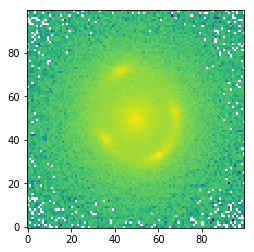

In [6]:
plt.imshow(np.log10(image_sim), origin='lower')
plt.show()

### Convert the convergence map to lens model

Mostly inspired by the `light2mass_interpol(...)` method in `lenstronomy.Analysis.lens_analysis`

In [7]:
from lenstronomy.LensModel.numerical_profile_integrals import ConvergenceIntegrals
from lenstronomy.LensModel.numeric_lens_differentials import NumericLens
from lenstronomy.LensModel.Profiles.interpol import Interpol

x_grid, y_grid = lenstro_util.make_grid(numPix=num_pix, deltapix=delta_pix)

# subgrid resolution (supersampling factor), 1 if no need to get higher resolution maps
# if resolution is  not high enough, inaccuracies can make new point sources to appear... ;)
subgrid_res = 3

x_grid_sub, y_grid_sub = lenstro_util.make_grid(numPix=num_pix*5, deltapix=delta_pix, subgrid_res=subgrid_res)

# get the convergence map from previous mass model (or one that you provide !)
convergence_sub = lens_model_class.kappa(x_grid_sub, y_grid_sub, kwargs_lens)

# compute the integrals to get alpha and potential
integral = ConvergenceIntegrals()
f_x_sub, f_y_sub = integral.deflection_from_kappa(convergence_sub, x_grid_sub, y_grid_sub,
                                                  deltaPix=delta_pix/float(subgrid_res))

f_sub = integral.potential_from_kappa(convergence_sub, x_grid_sub, y_grid_sub,
                                      deltaPix=delta_pix/float(subgrid_res))

x_axes_sub, y_axes_sub = lenstro_util.get_axes(x_grid_sub, y_grid_sub)

# interpolation function on lensing quantities
interp_func = Interpol()
interp_func.do_interp(x_axes_sub, y_axes_sub, f_sub, f_x_sub, f_y_sub)

# compute lensing quantities on sparser grid
x_axes, y_axes = lenstro_util.get_axes(x_grid, y_grid)
f_ = interp_func.function(x_grid, y_grid)
f_x, f_y = interp_func.derivatives(x_grid, y_grid)

kwargs_temp = [{'grid_interp_x': x_axes_sub, 'grid_interp_y': y_axes_sub, 'f_': f_sub,
                'f_x': f_x_sub, 'f_y': f_y_sub}]

# numerical differentials for second order differentials
lens_differential = NumericLens(lens_model_list=['INTERPOL'])

f_xx, f_xy, f_yx, f_yy = lens_differential.hessian(x_grid, y_grid, kwargs_temp)
kwargs_interpol = {'grid_interp_x': x_axes, 
                   'grid_interp_y': y_axes, 
                   'f_': lenstro_util.array2image(f_),
                   'f_x': lenstro_util.array2image(f_x), 
                   'f_y': lenstro_util.array2image(f_y), 
                   'f_xx': lenstro_util.array2image(f_xx),
                   'f_xy': lenstro_util.array2image(f_xy), 
                   'f_yy': lenstro_util.array2image(f_yy)}

#print(kwargs_interpol)

### Compare lens models

#### Original lens model

/Users/aymericg/anaconda2/envs/pystro36/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


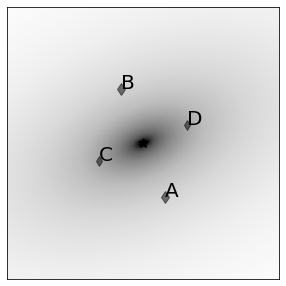

In [8]:
f, axes = plt.subplots(1, figsize=(5, 5), sharex=False, sharey=False)
output_plots.lens_model_plot(axes, lensModel=lens_model_class, kwargs_lens=kwargs_lens, 
                             sourcePos_x=0.0, sourcePos_y=0.0, point_source=True, with_caustics=False)
f.show()

#### Lens model interpolated from $\kappa$ map

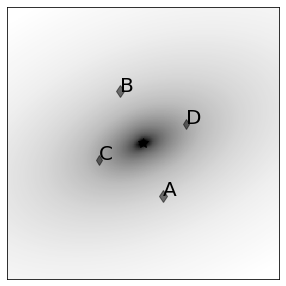

In [9]:
lens_model_class_interpol = LensModel(lens_model_list=['INTERPOL'])
kwargs_lens_interpol = [kwargs_interpol]

f, axex = plt.subplots(1, figsize=(5, 5), sharex=False, sharey=False)
output_plots.lens_model_plot(axex, lensModel=lens_model_class_interpol, kwargs_lens=kwargs_lens_interpol, 
                             sourcePos_x=0.0, sourcePos_y=0.0, point_source=True, with_caustics=False)
f.show()

Then you just need to use your `lens_model_class_interpol` instead of `lens_model_class`, and `kwargs_lens_interpol` instead of `lens_model_class` to generate a lens image like the one above (cell 5).